In [1]:
import pandas as pd
import numpy as np
import os # For potential file path operations

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import scikit-learn utilities
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
#from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report
from sklearn.feature_selection import RFE, SelectFromModel

# Import models (add more as needed)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier # Uncomment if XGBoost is installed and needed
# from lightgbm import LGBMClassifier # Uncomment if LightGBM is installed and needed

# Import imbalanced-learn for handling imbalance
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, SMOTEN
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

from imblearn.pipeline import Pipeline
# Import model explainability libraries
#import shap
import joblib # For saving/loading models
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
# Import utility for ignoring warnings
import warnings

# Add project root to Python path to fix import issues
import sys
import os

# Get the current working directory and add the parent directory to Python path
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.insert(0, project_root)
from src.data_processing import DataProcessor
data_processor = DataProcessor("../config.yaml")

# Define a random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED) # Set seed for numpy



# Configure settings
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output


sns.set_theme(style="whitegrid")

## Data Processing

In [2]:
# Load data using our data processor
df = data_processor.load_data("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Clean the data
df_clean = data_processor.clean_data(df)

# Display basic information
print(f"Dataset shape: {df_clean.shape}")
print(f"\nChurn distribution:")
print(df_clean['Churn'].value_counts(normalize=True))
df_engineered = data_processor.calculate_derived_features(df_clean)

INFO:src.data_processing:Data loaded successfully from ../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv. Shape: (7043, 21)
INFO:src.data_processing:Converted and imputed TotalCharges. Found 0 remaining missing values (should be 0)
INFO:src.data_processing:Created MonthlyToTotalRatio feature
INFO:src.data_processing:Created NumAdditionalServices feature
INFO:src.data_processing:Dropped original service columns: ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
INFO:src.data_processing:Created HasInternetService feature
INFO:src.data_processing:Dropped original InternetService column


Dataset shape: (7043, 21)

Churn distribution:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [3]:
X, y = data_processor.prepare_features(df_engineered)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% for the test set
    random_state=42, # Use the defined random seed
    stratify=y            # Ensure class distribution is similar in train/test
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Churn distribution in y_train:\n{y_train.value_counts(normalize=True)}")
print(f"Churn distribution in y_test:\n{y_test.value_counts(normalize=True)}")

X_train shape: (5634, 15)
X_test shape: (1409, 15)
y_train shape: (5634,)
y_test shape: (1409,)
Churn distribution in y_train:
Churn
No     0.734647
Yes    0.265353
Name: proportion, dtype: float64
Churn distribution in y_test:
Churn
No     0.734564
Yes    0.265436
Name: proportion, dtype: float64


In [4]:
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'SeniorCitizen' in numerical_features:
    numerical_features.remove('SeniorCitizen') # Remove if present

categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
# Add 'SeniorCitizen' to categorical features
categorical_features.append('SeniorCitizen')

# Include newly engineered features if they are numeric
engineered_numeric = ['MonthlyToTotalRatio', 'NumAdditionalServices', 'HasInternetService']
for feat in engineered_numeric:
    if feat in X_train.columns and feat not in numerical_features:
         # Check if it's actually numeric in the DataFrame
         if pd.api.types.is_numeric_dtype(X_train[feat]):
              numerical_features.append(feat)
    # If engineered features were object type, they'd be caught by select_dtypes('object')

# Transform churn to binary directly
y_train = (y_train == 'Yes').astype(int)
y_test = (y_test == 'Yes').astype(int)

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

Numerical features (6): ['tenure', 'MonthlyCharges', 'TotalCharges', 'MonthlyToTotalRatio', 'NumAdditionalServices', 'HasInternetService']
Categorical features (10): ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']


In [5]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Create the preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

In [6]:
# This learns the medians, scales, and categories from X_train
preprocessor.fit(X_train)
print("Preprocessor fitted on X_train.")

# Transform both the training and testing data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

Preprocessor fitted on X_train.


## Modeling & Evaluation

### Basic Logistic Regression

In [7]:
baseline_lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', None), # No resampling for this baseline check
    ('classifier', LogisticRegression(random_state=RANDOM_SEED, max_iter=1000))
])
baseline_lr_pipe.fit(X_train, y_train)
y_pred_lr_base = baseline_lr_pipe.predict(X_test)
y_pred_proba_lr_base = baseline_lr_pipe.predict_proba(X_test)[:, 1]

print("\nBasic Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr_base))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_lr_base):.4f}")

model_results = {
    'Accuracy': accuracy_score(y_test, y_pred_lr_base),
    'Precision': precision_score(y_test, y_pred_lr_base),
    'Recall': recall_score(y_test, y_pred_lr_base),
    'F1': f1_score(y_test, y_pred_lr_base),
    'ROC_AUC': roc_auc_score(y_test, y_pred_proba_lr_base),
    'ConfusionMatrix': confusion_matrix(y_test, y_pred_lr_base),
    'Report': classification_report(y_test, y_pred_lr_base),
    'Proba': y_pred_proba_lr_base,
    'Pipeline': baseline_lr_pipe
}
print('Accuracy:', model_results['Accuracy'])
print('Precision:', model_results['Precision'])
print('Recall:', model_results['Recall'])
print('F1:', model_results['F1'])
print('ROC_AUC:', model_results['ROC_AUC'])
print("Confusion Matrix:\n", model_results['ConfusionMatrix'])


Basic Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409

ROC AUC: 0.8489
Accuracy: 0.8019872249822569
Precision: 0.6537216828478964
Recall: 0.5401069518716578
F1: 0.5915080527086384
ROC_AUC: 0.848916272701439
Confusion Matrix:
 [[928 107]
 [172 202]]


In [8]:
joblib.dump(baseline_lr_pipe, '../models/best_log_baseline_pipeline_bayes.pkl')

print("\nBest Logistic Regression pipeline saved to ../models/best_log_baseline_pipeline_bayes.pkl")


Best Logistic Regression pipeline saved to ../models/best_log_baseline_pipeline_bayes.pkl


### Random Forrest

In [9]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
scoring_metric = 'f1' # Optimize for F1 during search (balance)
n_iterations = 50 # Number of parameter settings that are sampled (adjust as needed)

# --- Random Forest Tuning ---

# Define the base pipeline structure for Random Forest
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', None), # Placeholder for resampling techniques
    ('classifier', RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1))
])

# Define parameter ranges for Random Forest classifier
rf_param_ranges = {
    'classifier__n_estimators': [100, 200, 300, 400],
    'classifier__max_depth': [5, 10, 15, 20, None],
    'classifier__max_features': ['sqrt', 'log2', 0.3], # Use 'sqrt' instead of 'auto'
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 3, 5],
    'classifier__bootstrap': [True, False]
    # 'classifier__criterion': ['gini', 'entropy'] # Can add if desired
}

# Define resampling options to test
resampling_options = [
    (None, {}), # No resampling
    (SMOTE(random_state=RANDOM_SEED), {'resampler__k_neighbors': [3, 5, 7]}),
    (RandomUnderSampler(random_state=RANDOM_SEED), {'resampler__sampling_strategy': [0.3, 0.5, 0.7]}),
    (RandomOverSampler(random_state=RANDOM_SEED), {'resampler__sampling_strategy': [0.5, 0.7, 1.0]}),

    (ADASYN(random_state=RANDOM_SEED), {'resampler__n_neighbors': [3, 5, 7]}),
    (SMOTEN(random_state=RANDOM_SEED), {'resampler__k_neighbors': [3, 5, 7]}),
    (ClusterCentroids(random_state=RANDOM_SEED), {'resampler__sampling_strategy': [0.5, 0.7, 1.0]}),
    
    
]

# Create the parameter grid list for RandomizedSearchCV
param_grid_rf = []
for resampler, resampler_params in resampling_options:
    # Base config for this resampler
    config = {
        'resampler': [resampler],
        **rf_param_ranges # Add classifier ranges
    }
    # Add specific parameters for the current resampler
    config.update(resampler_params)

    # Add class_weight options (test only when NO external resampling is active)
    if resampler is None:
         config['classifier__class_weight'] = [None, 'balanced', 'balanced_subsample']
    else:
         config['classifier__class_weight'] = [None] # Don't use internal weighting with external resampling

    param_grid_rf.append(config)


# Setup RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_grid_rf,
    n_iter=n_iterations,
    scoring=scoring_metric,
    refit=scoring_metric, # Refit the best estimator found using the whole training set
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1, # Use all available CPU cores
    random_state=RANDOM_SEED
)

print(f"\nStarting RandomizedSearchCV for RandomForest (n_iter={n_iterations})...")

random_search_rf.fit(X_train, y_train)



Starting RandomizedSearchCV for RandomForest (n_iter=50)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['tenure',
                                                                                'MonthlyCharges',
                                                                                'TotalCharges',
                                                                                'MonthlyToTotalRatio',
                                                                                'NumAdditio...
                                         'classifier__max_depth': [5, 10, 15,
                                                                   20, None],
                                         'classifier__max_features': ['sqrt',
                                                                      'log2',
                                                                      0.3],
                                         'classifier__min_samples_leaf': [1, 3,
                                                                          5],
                                         'classifier__min_samples_split': [2, 5,
                                                                           10],
                                         'classifier__n_estimators': [100, 200,
                                                                      300,
                                                                      400],
                                         'resampler': [ClusterCentroids(random_state=42)],
                                         'resampler__sampling_strategy': [0.5,
                                                                          0.7,
                                                                          1.0]}],
                   random_state=42, refit='f1', scoring='f1', verbose=1)

In [10]:
print(random_search_rf.best_params_)
print(f"\nBest Cross-Validation {scoring_metric.upper()} Score (Random Forest): {random_search_rf.best_score_:.4f}")

# Store the best RF estimator
best_rf_pipeline = random_search_rf.best_estimator_


{'resampler__sampling_strategy': 1.0, 'resampler': RandomOverSampler(random_state=42), 'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 5, 'classifier__max_features': 'log2', 'classifier__max_depth': 10, 'classifier__class_weight': None, 'classifier__bootstrap': True}

Best Cross-Validation F1 Score (Random Forest): 0.6311


In [11]:
y_pred_rf = best_rf_pipeline.predict(X_test)
y_pred_proba_rf = best_rf_pipeline.predict_proba(X_test)[:, 1]


In [12]:
model_results = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1': f1_score(y_test, y_pred_rf),
    'ROC_AUC': roc_auc_score(y_test, y_pred_proba_rf),
    'ConfusionMatrix': confusion_matrix(y_test, y_pred_rf),
    'Report': classification_report(y_test, y_pred_rf),
    'Proba': y_pred_proba_rf,
    'Pipeline': best_rf_pipeline
}
print('Accuracy:', model_results['Accuracy'])
print('Precision:', model_results['Precision'])
print('Recall:', model_results['Recall'])
print('F1:', model_results['F1'])
print('ROC_AUC:', model_results['ROC_AUC'])
print("Confusion Matrix:\n", model_results['ConfusionMatrix'])

Accuracy: 0.7579843860894251
Precision: 0.5295169946332737
Recall: 0.7914438502673797
F1: 0.6345123258306538
ROC_AUC: 0.8435906378361622
Confusion Matrix:
 [[772 263]
 [ 78 296]]


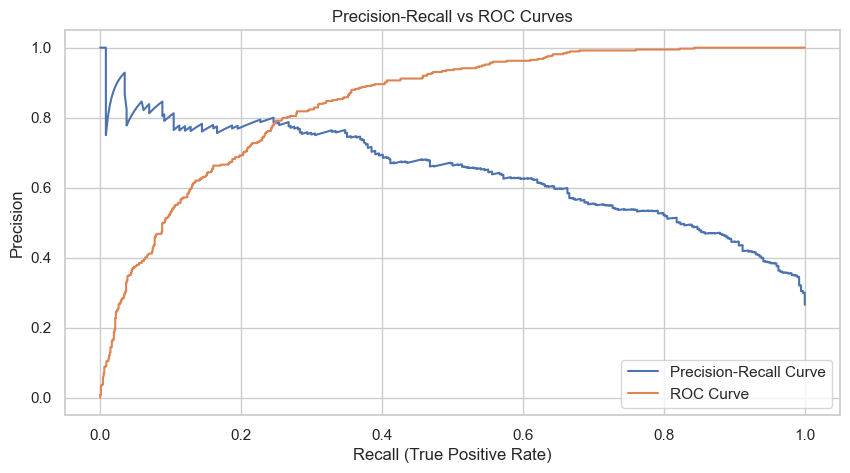

In [13]:
y_scores_rf = best_rf_pipeline.predict_proba(X_test)[:, 1]  # Probability of positive class

# Get binary predictions for metrics
y_pred_rf = best_rf_pipeline.predict(X_test)

# Calculate precision-recall curve
precision_rf, recall_rf, thresholds_pr = precision_recall_curve(y_test, y_scores_rf)

# Calculate ROC curve
fpr_rf, tpr_rf, thresholds_roc = roc_curve(y_test, y_scores_rf)

# Plot both curves
plt.figure(figsize=(10, 5))
plt.plot(recall_rf, precision_rf, label='Precision-Recall Curve')
plt.plot(fpr_rf, tpr_rf, label='ROC Curve')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall vs ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

In [14]:



pipeline_rf_bayes = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', RandomOverSampler(random_state=42, sampling_strategy=1.0)), # SMOTE instance is fine hereSMOTE(random_state=42)
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])


search_spaces_rf_bayes = {

    'resampler__sampling_strategy': Real(0.8, 1.0, prior='uniform'),

    'classifier__class_weight': Categorical([None]),
    'classifier__bootstrap': Categorical([True]),

    'classifier__n_estimators': Integer(180, 220, prior='uniform'),
    'classifier__max_depth': Integer(8, 12, prior='uniform'),
    'classifier__max_features': Categorical(['log2']),
    'classifier__min_samples_split': Integer(8, 12, prior='uniform'),
    'classifier__min_samples_leaf': Integer(4, 6, prior='uniform'),
}

n_iterations_rf_bayes = 50 # Number of iterations for Bayesian optimization
scoring_metric = 'f1'
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

bayes_search_rf = BayesSearchCV(
    estimator=pipeline_rf_bayes, # Use the corrected pipeline
    search_spaces=search_spaces_rf_bayes, # Use the corrected search space
    n_iter=n_iterations_rf_bayes,
    scoring=scoring_metric,
    cv=cv_strategy,
    n_jobs=-1,
    refit=True,
    random_state=42,
    verbose=1
)


In [15]:
bayes_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('num',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('scaler',
                                                                                           StandardScaler())]),
                                                                          ['tenure',
                                                                           'MonthlyCharges',
                                                                           'TotalCharges',
                                                                           'MonthlyToTotalRatio',
                                                                           'NumAdditionalSe...
                             'classifier__min_samples_leaf': Integer(low=4, high=6, prior='uniform', transform='normalize'),
                             'classifier__min_samples_split': Integer(low=8, high=12, prior='uniform', transform='normalize'),
                             'classifier__n_estimators': Integer(low=180, high=220, prior='uniform', transform='normalize'),
                             'resampler__sampling_strategy': Real(low=0.8, high=1.0, prior='uniform', transform='normalize')},
              verbose=1)

In [16]:
print(bayes_search_rf.best_params_)
print(f"\nBest Cross-Validation {scoring_metric.upper()} Score (Random Forest): {bayes_search_rf.best_score_:.4f}")

# Store the best RF estimator
best_rf_pipeline_bayes = bayes_search_rf.best_estimator_

OrderedDict([('classifier__bootstrap', True), ('classifier__class_weight', None), ('classifier__max_depth', 8), ('classifier__max_features', 'log2'), ('classifier__min_samples_leaf', 4), ('classifier__min_samples_split', 12), ('classifier__n_estimators', 212), ('resampler__sampling_strategy', 0.9258112243519689)])

Best Cross-Validation F1 Score (Random Forest): 0.6331


In [17]:
joblib.dump(best_rf_pipeline_bayes, '../models/best_rf_pipeline_bayes.pkl')

print("\nBest RF pipeline saved to ../models/best_rf_pipeline_bayes.pkl")


Best RF pipeline saved to ../models/best_rf_pipeline_bayes.pkl


In [18]:
y_pred_rf_bayes = best_rf_pipeline_bayes.predict(X_test)
y_pred_proba_rf_bayes = best_rf_pipeline_bayes.predict_proba(X_test)[:, 1]
model_results = {
    'Accuracy': accuracy_score(y_test, y_pred_rf_bayes),
    'Precision': precision_score(y_test, y_pred_rf_bayes),
    'Recall': recall_score(y_test, y_pred_rf_bayes),
    'F1': f1_score(y_test, y_pred_rf_bayes),
    'ROC_AUC': roc_auc_score(y_test, y_pred_proba_rf_bayes),
    'ConfusionMatrix': confusion_matrix(y_test, y_pred_rf_bayes),
    'Report': classification_report(y_test, y_pred_rf_bayes),
    'Proba': y_pred_proba_rf_bayes,
    'Pipeline': best_rf_pipeline_bayes
}
print('Accuracy:', model_results['Accuracy'])
print('Precision:', model_results['Precision'])
print('Recall:', model_results['Recall'])
print('F1:', model_results['F1'])
print('ROC_AUC:', model_results['ROC_AUC'])
print("Confusion Matrix:\n", model_results['ConfusionMatrix'])

Accuracy: 0.7530163236337828
Precision: 0.5231316725978647
Recall: 0.786096256684492
F1: 0.6282051282051282
ROC_AUC: 0.8440517709059909
Confusion Matrix:
 [[767 268]
 [ 80 294]]


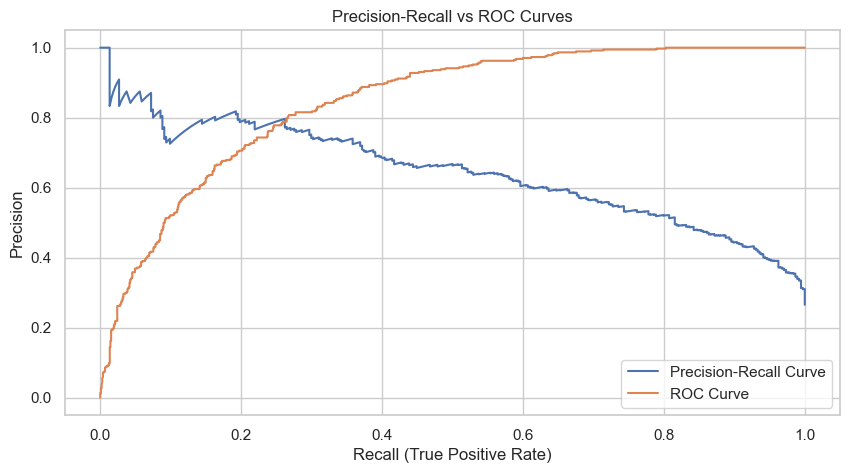

In [19]:
y_scores_xgb = best_rf_pipeline_bayes.predict_proba(X_test)[:, 1]  # Probability of positive class

# Get binary predictions for metrics
y_pred_xgb = best_rf_pipeline_bayes.predict(X_test)

# Calculate precision-recall curve
precision_xgb, recall_xgb, thresholds_pr = precision_recall_curve(y_test, y_scores_xgb)

# Calculate ROC curve
fpr_xgb, tpr_xgb, thresholds_roc = roc_curve(y_test, y_scores_xgb)

# Plot both curves
plt.figure(figsize=(10, 5))
plt.plot(recall_xgb, precision_xgb, label='Precision-Recall Curve')
plt.plot(fpr_xgb, tpr_xgb, label='ROC Curve')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall vs ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

### Gradient Boosting

In [20]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
scoring_metric = 'f1' # Optimize for F1 during search (balance)
n_iterations = 50 # Number of parameter settings that are sampled (adjust as needed)

# --- Random Forest Tuning ---

# Define the base pipeline structure for Random Forest
pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', None), # Placeholder for resampling techniques
    ('classifier', GradientBoostingClassifier(random_state=RANDOM_SEED))
])

gb_param_ranges = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 3, 5],
    'classifier__subsample': [0.7, 0.8, 0.9, 1.0] # Fraction of samples used for fitting trees
    # 'classifier__max_features': ['sqrt', 'log2', None] # Can add if desired
}
# Define resampling options to test
resampling_options = [
    (None, {}), # No resampling
    (SMOTE(random_state=RANDOM_SEED), {'resampler__k_neighbors': [3, 5, 7]}),
    (RandomUnderSampler(random_state=RANDOM_SEED), {'resampler__sampling_strategy': [0.3, 0.5, 0.7]}),
    (RandomOverSampler(random_state=RANDOM_SEED), {'resampler__sampling_strategy': [0.5, 0.7, 1.0]}),
    # Add more like ADASYN, SMOTEENN if desired
    # (ADASYN(random_state=RANDOM_SEED), {'resampler__n_neighbors': [3, 5, 7]}),
    # (SMOTEENN(random_state=RANDOM_SEED), {})
]



# Create the parameter grid list for RandomizedSearchCV for GB
param_grid_gb = []
for resampler, resampler_params in resampling_options:
    config = {
        'resampler': [resampler],
        **gb_param_ranges # Add classifier ranges
    }
    config.update(resampler_params)
    # GradientBoostingClassifier does not have class_weight, so no need to add logic for it
    param_grid_gb.append(config)

# Setup RandomizedSearchCV for Gradient Boosting
random_search_gb = RandomizedSearchCV(
    pipeline_gb,
    param_distributions=param_grid_gb,
    n_iter=n_iterations, # Use same number of iterations
    scoring=scoring_metric,
    refit=scoring_metric,
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

print(f"\nStarting RandomizedSearchCV for Gradient Boosting (n_iter={n_iterations})...")

random_search_gb.fit(X_train, y_train)



Starting RandomizedSearchCV for Gradient Boosting (n_iter=50)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['tenure',
                                                                                'MonthlyCharges',
                                                                                'TotalCharges',
                                                                                'MonthlyToTotalRatio',
                                                                                'NumAdditio...
                                                                       0.1,
                                                                       0.2],
                                         'classifier__max_depth': [3, 4, 5, 6],
                                         'classifier__min_samples_leaf': [1, 3,
                                                                          5],
                                         'classifier__min_samples_split': [2, 5,
                                                                           10],
                                         'classifier__n_estimators': [100, 200,
                                                                      300],
                                         'classifier__subsample': [0.7, 0.8,
                                                                   0.9, 1.0],
                                         'resampler': [RandomOverSampler(random_state=42)],
                                         'resampler__sampling_strategy': [0.5,
                                                                          0.7,
                                                                          1.0]}],
                   random_state=42, refit='f1', scoring='f1', verbose=1)

In [21]:
print(random_search_gb.best_params_)
print(f"\nBest Cross-Validation {scoring_metric.upper()} Score (Gradient Boosting): {random_search_gb.best_score_:.4f}")

# Store the best RF estimator
best_gb_pipeline = random_search_gb.best_estimator_

y_pred_gb = best_gb_pipeline.predict(X_test)
y_pred_proba_gb = best_gb_pipeline.predict_proba(X_test)[:, 1]

model_results = {
    'Accuracy': accuracy_score(y_test, y_pred_gb),
    'Precision': precision_score(y_test, y_pred_gb),
    'Recall': recall_score(y_test, y_pred_gb),
    'F1': f1_score(y_test, y_pred_gb),
    'ROC_AUC': roc_auc_score(y_test, y_pred_proba_gb),
    'ConfusionMatrix': confusion_matrix(y_test, y_pred_gb),
    'Report': classification_report(y_test, y_pred_gb),
    'Proba': y_pred_proba_gb,
    'Pipeline': best_gb_pipeline
}
print('Accuracy:', model_results['Accuracy'])
print('Precision:', model_results['Precision'])
print('Recall:', model_results['Recall'])
print('F1:', model_results['F1'])
print('ROC_AUC:', model_results['ROC_AUC'])
print("Confusion Matrix:\n", model_results['ConfusionMatrix'])
 # Probability of positive class



{'resampler__k_neighbors': 7, 'resampler': SMOTE(random_state=42), 'classifier__subsample': 0.9, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 5, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.01}

Best Cross-Validation F1 Score (Gradient Boosting): 0.6296
Accuracy: 0.7551454932576295
Precision: 0.528046421663443
Recall: 0.7299465240641712
F1: 0.6127946127946128
ROC_AUC: 0.8361027151308482
Confusion Matrix:
 [[791 244]
 [101 273]]


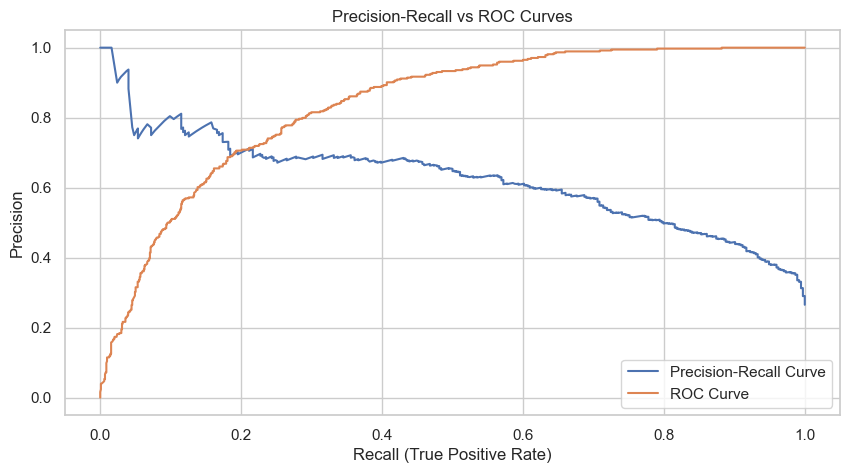

In [22]:
y_scores_gb = best_gb_pipeline.predict_proba(X_test)[:, 1]  # Probability of positive class

# Get binary predictions for metrics
y_pred_gb = best_gb_pipeline.predict(X_test)

# Calculate precision-recall curve
precision_gb, recall_gb, thresholds_pr = precision_recall_curve(y_test, y_scores_gb)

# Calculate ROC curve
fpr_gb, tpr_gb, thresholds_roc = roc_curve(y_test, y_scores_gb)

# Plot both curves
plt.figure(figsize=(10, 5))
plt.plot(recall_gb, precision_gb, label='Precision-Recall Curve')
plt.plot(fpr_gb, tpr_gb, label='ROC Curve')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall vs ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
pipeline_gb_bayes = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(
        random_state=42
    ))
])

# Update search space for Gradient Boosting parameters
search_spaces_gb_bayes = {
    'resampler__k_neighbors': Integer(2, 5, prior='uniform'),  # Explore around best value of 3
    
    # Gradient Boosting specific parameters
    'classifier__n_estimators': Integer(250, 350, prior='uniform'),  # Explore around 300
    'classifier__learning_rate': Real(0.005, 0.02, prior='log-uniform'),  # Explore around 0.01
    'classifier__max_depth': Integer(2, 5, prior='uniform'),  # Explore around 3
    'classifier__min_samples_split': Integer(3, 7, prior='uniform'),  # Explore around 5
    'classifier__min_samples_leaf': Integer(2, 5, prior='uniform'),  # Explore around 3
    'classifier__subsample': Real(0.7, 0.9, prior='uniform'),  # Explore around 0.8
}

n_iterations_gb_bayes = 50  # Number of iterations for Bayesian optimization
scoring_metric = 'f1'
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

bayes_search_gb = BayesSearchCV(
    estimator=pipeline_gb_bayes,
    search_spaces=search_spaces_gb_bayes,
    n_iter=n_iterations_gb_bayes,
    scoring=scoring_metric,
    cv=cv_strategy,
    n_jobs=-1,
    refit=True,
    random_state=42,
    verbose=1
)


In [24]:
bayes_search_gb.fit(X_train, y_train)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('num',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('scaler',
                                                                                           StandardScaler())]),
                                                                          ['tenure',
                                                                           'MonthlyCharges',
                                                                           'TotalCharges',
                                                                           'MonthlyToTotalRatio',
                                                                           'NumAdditionalSe...
                             'classifier__min_samples_split': Integer(low=3, high=7, prior='uniform', transform='normalize'),
                             'classifier__n_estimators': Integer(low=250, high=350, prior='uniform', transform='normalize'),
                             'classifier__subsample': Real(low=0.7, high=0.9, prior='uniform', transform='normalize'),
                             'resampler__k_neighbors': Integer(low=2, high=5, prior='uniform', transform='normalize')},
              verbose=1)

In [25]:
print(bayes_search_gb.best_params_)
print(f"\nBest Cross-Validation {scoring_metric.upper()} Score (Gradient Boosting): {bayes_search_gb.best_score_:.4f}")

# Store the best RF estimator
best_gb_pipeline_bayes = bayes_search_gb.best_estimator_

OrderedDict([('classifier__learning_rate', 0.02), ('classifier__max_depth', 3), ('classifier__min_samples_leaf', 2), ('classifier__min_samples_split', 3), ('classifier__n_estimators', 290), ('classifier__subsample', 0.7), ('resampler__k_neighbors', 5)])

Best Cross-Validation F1 Score (Gradient Boosting): 0.6389


In [26]:
joblib.dump(best_gb_pipeline_bayes, '../models/best_gb_pipeline_bayes.pkl')

print("\nBest GB pipeline saved to ../models/best_gb_pipeline_bayes.pkl")


Best GB pipeline saved to ../models/best_gb_pipeline_bayes.pkl


In [27]:
y_pred_gb_bayes = best_gb_pipeline_bayes.predict(X_test)
y_pred_proba_gb_bayes = best_gb_pipeline_bayes.predict_proba(X_test)[:, 1]

model_results = {
    'Accuracy': accuracy_score(y_test, y_pred_gb_bayes),
    'Precision': precision_score(y_test, y_pred_gb_bayes),
    'Recall': recall_score(y_test, y_pred_gb_bayes),
    'F1': f1_score(y_test, y_pred_gb_bayes),
    'ROC_AUC': roc_auc_score(y_test, y_pred_proba_gb_bayes),
    'ConfusionMatrix': confusion_matrix(y_test, y_pred_gb_bayes),
    'Report': classification_report(y_test, y_pred_gb_bayes),
    'Proba': y_pred_proba_gb_bayes,
    'Pipeline': best_gb_pipeline_bayes
}
print('Accuracy:', model_results['Accuracy'])
print('Precision:', model_results['Precision'])
print('Recall:', model_results['Recall'])
print('F1:', model_results['F1'])
print('ROC_AUC:', model_results['ROC_AUC'])
print("Confusion Matrix:\n", model_results['ConfusionMatrix'])

Accuracy: 0.758694109297374
Precision: 0.5330739299610895
Recall: 0.732620320855615
F1: 0.6171171171171171
ROC_AUC: 0.8369978557958098
Confusion Matrix:
 [[795 240]
 [100 274]]


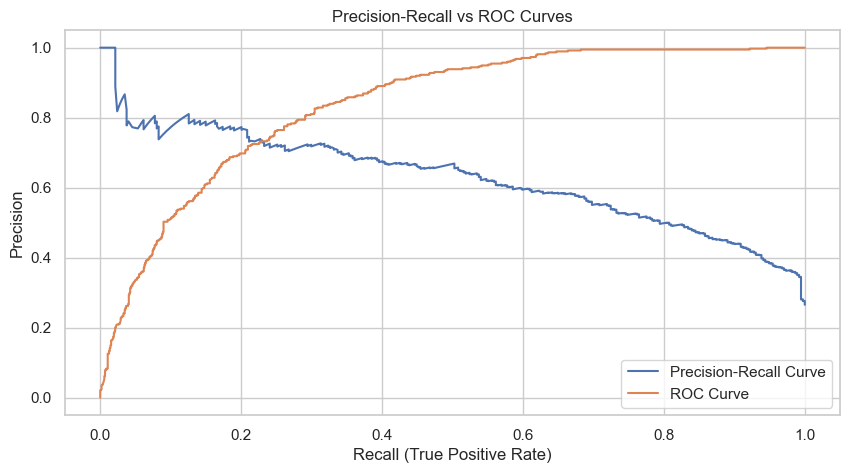

In [28]:
y_scores_gb_bayes = best_gb_pipeline_bayes.predict_proba(X_test)[:, 1]  # Probability of positive class

# Get binary predictions for metrics
y_pred_gb_bayes = best_gb_pipeline_bayes.predict(X_test)

# Calculate precision-recall curve
precision_gb_bayes, recall_gb_bayes, thresholds_pr = precision_recall_curve(y_test, y_scores_gb_bayes)

# Calculate ROC curve
fpr_gb_bayes, tpr_gb_bayes, thresholds_roc_bayes = roc_curve(y_test, y_scores_gb_bayes)

# Plot both curves
plt.figure(figsize=(10, 5))
plt.plot(recall_gb_bayes, precision_gb_bayes, label='Precision-Recall Curve')
plt.plot(fpr_gb_bayes, tpr_gb_bayes, label='ROC Curve')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall vs ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

### xgboost

In [29]:
# This is the recommended way to handle imbalance directly within XGBoost
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
# Handle potential division by zero if pos_count is 0 (though unlikely if it's the minority class)
scale_pos_weight_value = 1.0 if pos_count == 0 else neg_count / pos_count
print(f"Target scale_pos_weight for XGBoost: {scale_pos_weight_value:.2f}")
# ---

# 1. Define Pipeline with Scaler and XGBoost Classifier
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor), # Keep scaler for consistency
    ('resampler', None),          # Placeholder for resampling step
    ('classifier', XGBClassifier(
        random_state=42,
        objective='binary:logistic', # Objective for binary classification
        eval_metric='logloss',       # Common evaluation metric during training
    ))
])

# 2. Define Expanded Parameter Grid for XGBoost

# Common XGBoost parameter ranges to explore
xgb_param_ranges = {
    'classifier__n_estimators': [100, 200, 300, 400, 500], # More trees?
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7, 9], # Deeper trees?
    'classifier__subsample': [0.7, 0.8, 0.9, 1.0], # Row sampling
    'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0], # Column sampling per tree
    'classifier__gamma': [0, 0.1, 0.5, 1, 2], # Min loss reduction for split
    'classifier__reg_alpha': [0, 0.01, 0.1, 1], # L1 regularization
    'classifier__reg_lambda': [0.1, 1, 5, 10] # L2 regularization (often start > 0)
}

# Expanded resampler parameters
smote_k_neighbors = [3, 5, 10]
adasyn_n_neighbors = [3, 5, 10]
rus_sampling_strategy = [0.2, 0.35, 0.5] # Ratio minority/majority after RUS
ros_sampling_strategy = [0.5, 0.7, 1.0] # Ratio minority/majority after ROS

# List to hold all grid dictionaries
param_grid_xgb = []

# --- Configuration for NO Resampling ---

param_grid_xgb.append({
    'resampler': [None],
    **xgb_param_ranges,
    'classifier__scale_pos_weight': [1, scale_pos_weight_value] # Test default vs calculated weight
})

# --- Configurations for Resampling Methods --
resampling_options_list = [
    {'resampler': [SMOTE(random_state=42)], 'resampler__k_neighbors': smote_k_neighbors},
    #{'resampler': [ADASYN(random_state=42)], 'resampler__n_neighbors': adasyn_n_neighbors},
    {'resampler': [RandomOverSampler(random_state=42)], 'resampler__sampling_strategy': ros_sampling_strategy},
    {'resampler': [RandomUnderSampler(random_state=42)], 'resampler__sampling_strategy': rus_sampling_strategy},
    #{'resampler': [TomekLinks(sampling_strategy='auto')]},
    #{'resampler': [NearMiss(version=1)]}
]

for resampler_config in resampling_options_list:
    config = {
        **resampler_config,
        **xgb_param_ranges,
        'classifier__scale_pos_weight': [1] # Set to 1 (no weight) when resampling
    }
    param_grid_xgb.append(config)

# 3. Configure RandomizedSearchCV
n_iterations_xgb = 75 # Adjust based on time/resources (e.g., 50-150)
scoring_metric = 'f1' # Target F1 score directly
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=param_grid_xgb,
    n_iter=n_iterations_xgb,
    scoring=scoring_metric,
    refit=scoring_metric, # Refit the best model based on F1 score
    cv=cv_strategy,
    verbose=0,            # Show detailed progress
    n_jobs=-1,            # Use all CPU cores
    random_state=42
)


Target scale_pos_weight for XGBoost: 2.77


In [30]:

os.environ["PYTHONWARNINGS"] = 'ignore::UserWarning'
random_search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['tenure',
                                                                                'MonthlyCharges',
                                                                                'TotalCharges',
                                                                                'MonthlyToTotalRatio',
                                                                                'NumAdditio...
                                         'classifier__max_depth': [3, 5, 7, 9],
                                         'classifier__n_estimators': [100, 200,
                                                                      300, 400,
                                                                      500],
                                         'classifier__reg_alpha': [0, 0.01, 0.1,
                                                                   1],
                                         'classifier__reg_lambda': [0.1, 1, 5,
                                                                    10],
                                         'classifier__scale_pos_weight': [1],
                                         'classifier__subsample': [0.7, 0.8,
                                                                   0.9, 1.0],
                                         'resampler': [RandomUnderSampler(random_state=42)],
                                         'resampler__sampling_strategy': [0.2,
                                                                          0.35,
                                                                          0.5]}],
                   random_state=42, refit='f1', scoring='f1')

In [31]:
print(random_search_xgb.best_params_)
print(f"\nBest Cross-Validation {scoring_metric.upper()} Score (Gradient Boosting): {random_search_xgb.best_score_:.4f}")

# Store the best RF estimator
best_xgb_pipeline = random_search_xgb.best_estimator_

{'resampler__sampling_strategy': 0.7, 'resampler': RandomOverSampler(random_state=42), 'classifier__subsample': 0.8, 'classifier__scale_pos_weight': 1, 'classifier__reg_lambda': 0.1, 'classifier__reg_alpha': 1, 'classifier__n_estimators': 200, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.05, 'classifier__gamma': 2, 'classifier__colsample_bytree': 0.9}

Best Cross-Validation F1 Score (Gradient Boosting): 0.6317


In [32]:
# Make predictions
y_pred_xgb = best_xgb_pipeline.predict(X_test)
y_pred_proba_xgb = best_xgb_pipeline.predict_proba(X_test)[:, 1]

# Calculate and print metrics
model_results = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1': f1_score(y_test, y_pred_xgb),
    'ROC_AUC': roc_auc_score(y_test, y_pred_proba_xgb),
    'ConfusionMatrix': confusion_matrix(y_test, y_pred_xgb),
    'Report': classification_report(y_test, y_pred_xgb)
}

print('\nModel Performance Metrics:')
print('Accuracy:', model_results['Accuracy'])
print('Precision:', model_results['Precision'])
print('Recall:', model_results['Recall'])
print('F1:', model_results['F1'])
print('ROC_AUC:', model_results['ROC_AUC'])
print("\nConfusion Matrix:")
print(model_results['ConfusionMatrix'])
print("\nClassification Report:")
print(model_results['Report'])


Model Performance Metrics:
Accuracy: 0.7743080198722498
Precision: 0.5595744680851064
Recall: 0.7032085561497327
F1: 0.6232227488151659
ROC_AUC: 0.8431695471337415

Confusion Matrix:
[[828 207]
 [111 263]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1035
           1       0.56      0.70      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.77      0.78      1409



In [33]:
pipeline_xgb_bayes = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', RandomOverSampler(random_state=42, sampling_strategy=1.0)),
    ('classifier', XGBClassifier(
        random_state=42,
        objective='binary:logistic', # Objective for binary classification
        eval_metric='logloss',       # Common evaluation metric during training
      
    ))
])

# Update search space for Gradient Boosting parameters
search_spaces_xgb_bayes = {
    'resampler__sampling_strategy': Real(0.8, 1.0, prior='uniform'),  # Explore around best value of 1.0
    
    # XGBoost specific parameters
    'classifier__n_estimators': Integer(450, 550, prior='uniform'),  # Explore around 500
    'classifier__learning_rate': Real(0.005, 0.02, prior='log-uniform'),  # Explore around 0.01
    'classifier__max_depth': Integer(2, 4, prior='uniform'),  # Explore around 3
    'classifier__gamma': Real(0.05, 0.2, prior='uniform'),  # Explore around 0.1
    'classifier__subsample': Real(0.6, 0.8, prior='uniform'),  # Explore around 0.7
    'classifier__colsample_bytree': Real(0.6, 0.8, prior='uniform'),  # Explore around 0.7
    'classifier__reg_alpha': Real(0.005, 0.02, prior='uniform'),  # Explore around 0.01
    'classifier__reg_lambda': Real(0.05, 0.2, prior='uniform'),  # Explore around 0.1
    'classifier__scale_pos_weight': Real(0.8, 1.2, prior='uniform'),  # Explore around 1
}

n_iterations_xgb_bayes = 50  # Number of iterations for Bayesian optimization
scoring_metric = 'f1'
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

bayes_search_xgb = BayesSearchCV(
    estimator=pipeline_xgb_bayes,
    search_spaces=search_spaces_xgb_bayes,
    n_iter=n_iterations_xgb_bayes,
    scoring=scoring_metric,
    cv=cv_strategy,
    n_jobs=-1,
    refit=True,
    random_state=42,
    verbose=1
)


In [34]:
bayes_search_xgb.fit(X_train, y_train)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('num',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('scaler',
                                                                                           StandardScaler())]),
                                                                          ['tenure',
                                                                           'MonthlyCharges',
                                                                           'TotalCharges',
                                                                           'MonthlyToTotalRatio',
                                                                           'NumAdditionalSe...
                             'classifier__reg_lambda': Real(low=0.05, high=0.2, prior='uniform', transform='normalize'),
                             'classifier__scale_pos_weight': Real(low=0.8, high=1.2, prior='uniform', transform='normalize'),
                             'classifier__subsample': Real(low=0.6, high=0.8, prior='uniform', transform='normalize'),
                             'resampler__sampling_strategy': Real(low=0.8, high=1.0, prior='uniform', transform='normalize')},
              verbose=1)

In [35]:
print(bayes_search_xgb.best_params_)
print(f"\nBest Cross-Validation {scoring_metric.upper()} Score (Gradient Boosting): {bayes_search_xgb.best_score_:.4f}")

# Store the best RF estimator
best_xgb_pipeline_bayes = bayes_search_xgb.best_estimator_

OrderedDict([('classifier__colsample_bytree', 0.6), ('classifier__gamma', 0.05), ('classifier__learning_rate', 0.008464520496759586), ('classifier__max_depth', 4), ('classifier__n_estimators', 550), ('classifier__reg_alpha', 0.02), ('classifier__reg_lambda', 0.05), ('classifier__scale_pos_weight', 0.8), ('classifier__subsample', 0.6), ('resampler__sampling_strategy', 0.8)])

Best Cross-Validation F1 Score (Gradient Boosting): 0.6381


In [36]:
joblib.dump(best_xgb_pipeline_bayes, '../models/best_xgb_pipeline_bayes.pkl')

print("\nBest XGB pipeline saved to ../models/best_xgb_pipeline_bayes.pkl")


Best XGB pipeline saved to ../models/best_xgb_pipeline_bayes.pkl


In [37]:
# Make predictions
y_pred_xgb_bayes = best_xgb_pipeline_bayes.predict(X_test)
y_pred_proba_xgb_bayes = best_xgb_pipeline_bayes.predict_proba(X_test)[:, 1]

# Calculate and print metrics
model_results = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb_bayes),
    'Precision': precision_score(y_test, y_pred_xgb_bayes),
    'Recall': recall_score(y_test, y_pred_xgb_bayes),
    'F1': f1_score(y_test, y_pred_xgb_bayes),
    'ROC_AUC': roc_auc_score(y_test, y_pred_proba_xgb_bayes),
    'ConfusionMatrix': confusion_matrix(y_test, y_pred_xgb_bayes),
    'Report': classification_report(y_test, y_pred_xgb_bayes)
}

print('\nModel Performance Metrics:')
print('Accuracy:', model_results['Accuracy'])
print('Precision:', model_results['Precision'])
print('Recall:', model_results['Recall'])
print('F1:', model_results['F1'])
print('ROC_AUC:', model_results['ROC_AUC'])
print("\nConfusion Matrix:")
print(model_results['ConfusionMatrix'])
print("\nClassification Report:")
print(model_results['Report'])


Model Performance Metrics:
Accuracy: 0.7863733144073811
Precision: 0.5809312638580931
Recall: 0.7005347593582888
F1: 0.6351515151515151
ROC_AUC: 0.8462579761812499

Confusion Matrix:
[[846 189]
 [112 262]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1035
           1       0.58      0.70      0.64       374

    accuracy                           0.79      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.79      0.79      1409



## Save best Parameters to JSON

In [38]:
import json


best_params = {
    'random_forest': bayes_search_rf.best_params_,
    'xgboost': bayes_search_xgb.best_params_,
    'gradient_boosting': bayes_search_gb.best_params_,
}

with open('../models/best_hyperparameters.json', 'w') as f:
    json.dump(best_params, f, indent=2)